## <b>Import libraries<b>

In [1]:
import torch
import pandas as pd
import numpy as np
from collections import Counter
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from sklearn.metrics import f1_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import f1_score
from sklearn import model_selection
%matplotlib inline

In [2]:
#drew inspiration from
#https://github.com/dmesquita/understanding_pytorch_nn and
#https://github.com/msahamed/yelp_comments_classification_nlp/blob/master/word_embeddings.ipynb
#https://github.com/nyu-mll/DS-GA-1011-Fall2017/blob/master/week%20eight/Week%20Eight%20Solutions.ipynb
#https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
#https://github.com/claravania/lstm-pytorch/blob/master/model.py
#https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130
#https://github.com/hpanwar08/sentence-classification-pytorch/blob/master/Sentiment%20analysis%20pytorch.ipynb

In [3]:
#https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

In [4]:
#https://modelzoo.co/model/pytorch-nlp
#http://anie.me/On-Torchtext/
#https://readthedocs.org/projects/pytorchnlp/downloads/pdf/latest/
#https://github.com/A-Jacobson/CNN_Sentence_Classification/blob/master/WordVectors.ipynb

## <b> Data Processing<b>

In [5]:
train = pd.read_csv("../train_nn.csv")

In [6]:
#create labels

In [7]:
labels = ['CAPS', 'Obscenity', 'Threat', 'hatespeech', 'namecalling', 'negprejudice', 'noneng', 'porn', 'stereotypes']

for label in labels:
    cols = [label + str(x) for x in range(1,8)]
    train[label + '_num_yes'] = train[cols].sum(axis = 1)
    train[label] = pd.Series(train[label + '_num_yes'] >= 2).astype(int)

In [8]:
train = train.loc[train['clean_tweet'].isnull() == False,]

In [9]:
train.reset_index(inplace = True, drop = True)

In [10]:
vocab = Counter()

for text in train.clean_tweet:
    for word in text.split(' '):
        vocab[word.lower()]+=1

total_words = len(vocab)

def get_word_2_index(vocab):
    word2index = {}
    index2word = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i+1
        index2word[i+1] = word.lower()

    return word2index, index2word

word2index, index2word = get_word_2_index(vocab)

In [11]:
#should add 'UNK' here

word2index['PAD'] = 0
index2word[0] = 'PAD'

total_words = total_words + 1

In [12]:
def load_glove(path):
    """
    creates a dictionary mapping words to vectors from a file in glove format.
    """
    with open(path) as f:
        glove = {}
        for line in f.readlines():
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove[word] = vector
        return glove

In [15]:
glove_path = "/Users/carolineroper/Desktop/Capstone Project/Neural Network/glove.twitter.27B/glove.twitter.27B.200d.txt"
%time glove = load_glove(glove_path)

CPU times: user 1min 19s, sys: 19.4 s, total: 1min 38s
Wall time: 1min 50s


In [16]:
word2index['hello']

2467

In [17]:
glove['hello']

array([  3.46830010e-01,  -1.96119994e-01,  -3.49229991e-01,
        -2.81580001e-01,  -7.56269991e-01,  -4.00349982e-02,
         5.34219980e-01,   1.53270003e-03,  -2.19630003e-01,
        -5.67080021e-01,  -7.51120001e-02,   3.90740007e-01,
         1.92010000e-01,   4.80460003e-02,  -1.68009996e-01,
        -1.91400006e-01,   1.21619999e-01,  -2.25130007e-01,
         2.22759992e-02,  -2.76320010e-01,   1.07210003e-01,
        -5.81910014e-02,  -1.76540002e-01,  -2.06199996e-02,
        -3.97679992e-02,   1.26190007e-01,   1.89270005e-01,
         1.70169994e-01,  -2.34529991e-02,  -4.23489988e-01,
        -4.26400006e-02,  -2.81010002e-01,  -3.24609995e-01,
         3.08699995e-01,   9.45290029e-02,   1.35590002e-01,
        -5.02489984e-01,   3.00720006e-01,   1.58050001e-01,
         5.50790012e-01,  -3.70050013e-01,  -2.17209995e-01,
        -7.11619973e-01,   4.29749995e-01,  -1.24509996e-02,
        -2.42750004e-01,  -6.29020035e-02,   4.37549986e-02,
         5.90980016e-02,

In [18]:
matrix_len = len(vocab) + 1
weights_matrix = np.zeros((matrix_len, 200))
words_found = 0

for i, word in index2word.items():
    try: 
        weights_matrix[i] = glove[index2word[i]]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.rand(200)

In [19]:
words_found/len(vocab) #77% of words were found

0.7660614525139665

In [20]:
weights_matrix[0, ] = np.zeros(200) #initialize pad embedding to zero

In [21]:
weights_matrix[2467, ] #confirmed that at index "hello" we're seeing the glove vector for "hello"

array([  3.46830010e-01,  -1.96119994e-01,  -3.49229991e-01,
        -2.81580001e-01,  -7.56269991e-01,  -4.00349982e-02,
         5.34219980e-01,   1.53270003e-03,  -2.19630003e-01,
        -5.67080021e-01,  -7.51120001e-02,   3.90740007e-01,
         1.92010000e-01,   4.80460003e-02,  -1.68009996e-01,
        -1.91400006e-01,   1.21619999e-01,  -2.25130007e-01,
         2.22759992e-02,  -2.76320010e-01,   1.07210003e-01,
        -5.81910014e-02,  -1.76540002e-01,  -2.06199996e-02,
        -3.97679992e-02,   1.26190007e-01,   1.89270005e-01,
         1.70169994e-01,  -2.34529991e-02,  -4.23489988e-01,
        -4.26400006e-02,  -2.81010002e-01,  -3.24609995e-01,
         3.08699995e-01,   9.45290029e-02,   1.35590002e-01,
        -5.02489984e-01,   3.00720006e-01,   1.58050001e-01,
         5.50790012e-01,  -3.70050013e-01,  -2.17209995e-01,
        -7.11619973e-01,   4.29749995e-01,  -1.24509996e-02,
        -2.42750004e-01,  -6.29020035e-02,   4.37549986e-02,
         5.90980016e-02,

In [22]:
len(vocab.keys())

11456

In [188]:
weights_matrix.shape

(11457, 200)

In [25]:
def pad_data(s, length):
    padded = np.zeros((length,), dtype = np.int64)
    if len(s) > length: 
        padded = s[:length]
    else:
        padded[:len(s)] = s
    return np.array(padded)

In [26]:
train['clean_tweet'][3]

"join us 3/26 at our women 's history month instameet ! learn of a nurse who tended ailing soldiers here in 1862 ."

In [27]:
train['seq_len'] = [len(x.split(' ')) for x in train['clean_tweet']]

train['numeric'] = [[word2index[y] for y in x.split(' ')] for x in train['clean_tweet']]

train['padded_tweet'] = [pad_data(x, 25) for x in train.numeric]

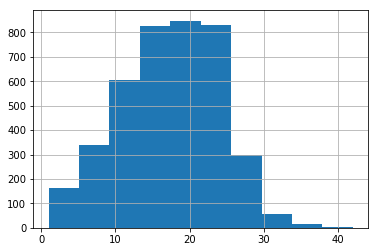

In [28]:
train.seq_len.hist()

In [ ]:
#if we want validation accuracy to better resemble test accuracy, need to create vocab on training only

In [29]:
train_sub, validation = model_selection.train_test_split(train, test_size = 0.2, random_state = 123)

In [30]:
# subclass the custom dataset class with torch.utils.data.Dataset
# implement __len__ and __getitem__ function
class VectorizeData(Dataset):
    def __init__(self, df, label, maxlen=20):
        self.df = df
        self.label = label

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.padded_tweet[idx]
        y = self.df[self.label][idx]
        lens = self.df.seq_len[idx]
        return X,y,lens

In [31]:
train_sub.reset_index(inplace = True, drop = True)

validation.reset_index(inplace = True, drop = True)

In [33]:
data = VectorizeData(train_sub, label = 'hatespeech')

dl = DataLoader(data, batch_size = 32, shuffle = True)

In [208]:
class LSTMClassifier(nn.Module):
    def __init__(self, weights, vocab_size, embedding_dim, hidden_dim, output_size, batch_size):
        super(LSTMClassifier, self).__init__()
        self.weights = weights
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(self.weights)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1)
        self.hidden2out = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax()
        self.dropout_layer = nn.Dropout(p=0.2)
        self.batch_size = batch_size
    
    def init_hidden(self, batch_size):
        return(autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)), \
               autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)))

    def forward(self, batch):
        self.hidden = self.init_hidden(batch_size)
        embeds = self.embedding(batch) 
        #packed_input = pack_padded_sequence(embeds, lengths)
        outputs, (ht, ct) = self.lstm(embeds, self.hidden)
        # ht is the last hidden state of the sequences
        # ht = (1 x batch_size x hidden_dim)
        # ht[-1] = (batch_size x hidden_dim)
        output = self.dropout_layer(ht[-1])
        output = self.hidden2out(output)
        output = self.softmax(output)
        return output

In [209]:
hidden_size = 200 
num_classes = 2
learning_rate = 0.001
num_epochs = 20
batch_size = 32
weights = torch.FloatTensor(weights_matrix)

In [210]:
def get_validation_loss(validation_data_loader, model):
    predictions = []
    pred_labels = []
    #get training predictions
    it = iter(validation_data_loader)
    num_batch = len(validation_data_loader) - 1
    # Loop over all batches
    for i in range(num_batch):
        batch_x,batch_y,batch_len = next(it)
        tweets = Variable(batch_x.transpose(0,1))
        labels = Variable(batch_y)
        lengths = Variable(batch_len)
        outputs = model(tweets)
        _, pred = torch.max(outputs.data, 1)
        predictions.extend(list(pred.numpy()))
        pred_labels.extend(list(labels.data.numpy()))
    return (f1_score(predictions, pred_labels))

In [ ]:
#add 1 because of pad token
net = LSTMClassifier(weights, total_words, hidden_size, hidden_size, num_classes, batch_size)

# Loss and Optimizer
criterion = nn.NLLLoss(weight = torch.Tensor([1/39,1]))  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#Validation Data
val = VectorizeData(validation, label = 'hatespeech')
dl2 = DataLoader(val, batch_size = 32, shuffle = False)

losses = []
val_scores = []

In [215]:
num_epochs = 10

num_batch = len(dl) - 1
# Train the Model
for epoch in range(num_epochs):
    it = iter(dl)
    # Loop over all batches
    for i in range(num_batch):
        batch_x,batch_y,batch_len = next(it)
        tweets = Variable(batch_x.transpose(0,1))
        labels = Variable(batch_y)
        lengths = Variable(batch_len)
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(tweets)
        loss = criterion(outputs, labels)
        losses.append(loss.data[0])
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(train.clean_tweet)//batch_size, loss.data[0]))
    val_scores.append(get_validation_loss(dl2, net))
    #if epoch > 5:
        #if np.mean(val_scores[-4:-1]) - np.mean(val_scores[-5:-2]) > 0.01:
            #best_net = net
        #else:
            #print ('done')
            #break

Epoch [1/10], Step [4/124], Loss: 0.0127
Epoch [1/10], Step [8/124], Loss: 0.0518
Epoch [1/10], Step [12/124], Loss: 0.0114
Epoch [1/10], Step [16/124], Loss: 0.0578
Epoch [1/10], Step [20/124], Loss: 0.0112
Epoch [1/10], Step [24/124], Loss: 0.0383
Epoch [1/10], Step [28/124], Loss: 0.0604
Epoch [1/10], Step [32/124], Loss: 0.0601
Epoch [1/10], Step [36/124], Loss: 0.0098
Epoch [1/10], Step [40/124], Loss: 0.0143
Epoch [1/10], Step [44/124], Loss: 0.0042
Epoch [1/10], Step [48/124], Loss: 0.0053
Epoch [1/10], Step [52/124], Loss: 0.0319
Epoch [1/10], Step [56/124], Loss: 0.0071
Epoch [1/10], Step [60/124], Loss: 0.0038
Epoch [1/10], Step [64/124], Loss: 0.0065
Epoch [1/10], Step [68/124], Loss: 0.0045
Epoch [1/10], Step [72/124], Loss: 0.0075
Epoch [1/10], Step [76/124], Loss: 0.0045
Epoch [1/10], Step [80/124], Loss: 0.0071
Epoch [1/10], Step [84/124], Loss: 0.0183
Epoch [1/10], Step [88/124], Loss: 0.0048
Epoch [1/10], Step [92/124], Loss: 0.1255
Epoch [1/10], Step [96/124], Loss: 0

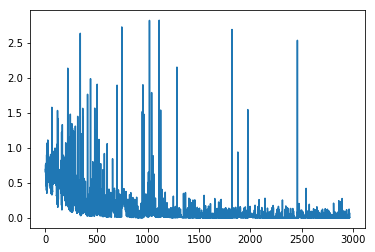

In [216]:
plt.plot(losses) #trained at lr of 0.01 for 30 epochs

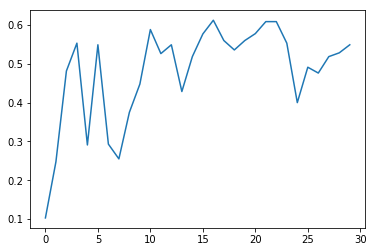

In [217]:
plt.plot(val_scores)

In [218]:
max(val_scores)

0.61224489795918358